# Dreambooth Kratos

### Setup

In [1]:
!pip install -Uqq diffusers transformers datasets accelerate ftfy bitsandbytes==0.35.0 wandb

In [1]:
import torch
from torch import Tensor
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import List, Dict
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel
from argparse import Namespace
import random
from tqdm.auto import tqdm
import math
import wandb
import os
import itertools
import datetime
import pytz
from PIL import Image

# set devie-agnostic code
device = (
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)

# covert PIL image to tensors
tensor2pil = transforms.ToPILImage()

# log in to WANDB
wandb.login()

wandb: Currently logged in as: matt24. Use `wandb login --relogin` to force relogin


True

In [2]:


def image_grid(images, rows, cols):
    '''helper function to assample a list of PIL images in a grid'''
    
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    
    return grid

### Dataset

In [3]:
from datasets import load_dataset

dataset_name = 'matteopilotto/kratos'
dataset = load_dataset(dataset_name, split='train')

dataset

Using custom data configuration matteopilotto--kratos-34c4f8400ee7980d
Found cached dataset parquet (/root/.cache/huggingface/datasets/matteopilotto___parquet/matteopilotto--kratos-34c4f8400ee7980d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image'],
    num_rows: 10
})

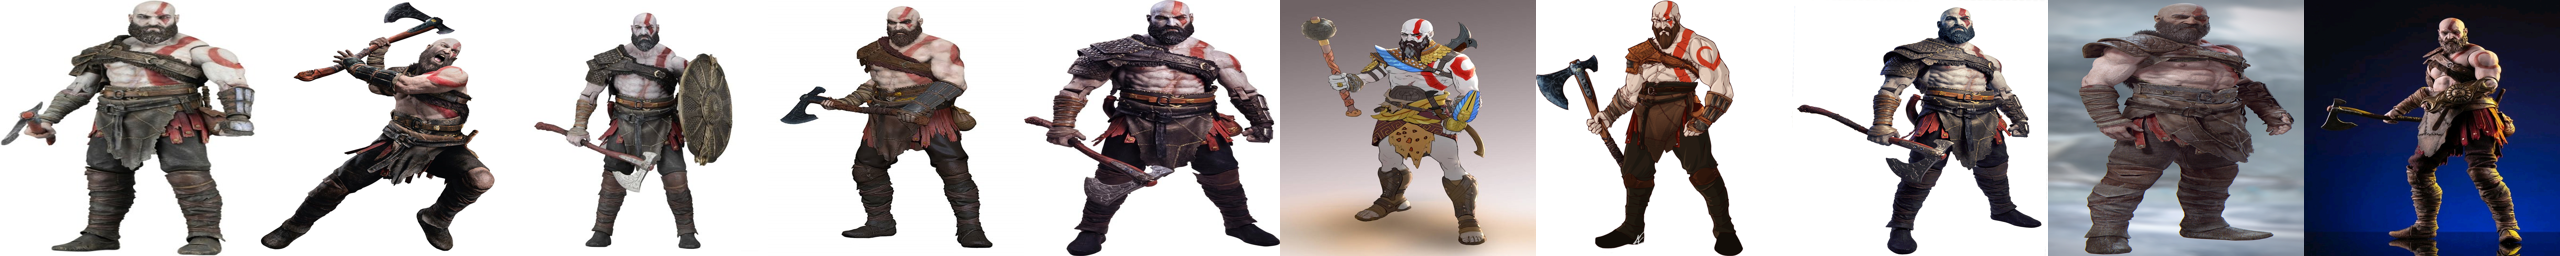

In [32]:
# visualize images (double click on the image below to make it larger)

image_grid([image.resize((256, 256)) for image in dataset['image']], rows=1, cols=len(dataset['image']))

In [5]:
# define unique token and class type to represent new concept to introduce with Dreambooth

unique_token = 'krts'
class_type = 'person'
instance_prompt = f'a photo of {unique_token} {class_type}'

print(instance_prompt)

a photo of krts person


In [6]:
'''
define custom dataset from Dreambooth.
Compare to the version shared in the hackathon notebook, center-cropping has been remove
since the images in the kratos dataset are already center-cropped.
'''

from torch.utils.data import Dataset
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, img_size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        # self.img_size = img_size
        
        self.img_transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            # transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]['image']
        example['instance_image'] = self.img_transforms(image)
        example['instance_input_ids'] = self.tokenizer(
                                            self.instance_prompt,
                                            padding='do_not_pad',
                                            truncation=True,
                                            max_length=self.tokenizer.model_max_length
                                        ).input_ids
        
        return example

In [23]:
from transformers import CLIPTokenizer

sd_ckpt = 'CompVis/stable-diffusion-v1-4'
tokenizer = CLIPTokenizer.from_pretrained(sd_ckpt, subfolder='tokenizer')

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer, img_size=512)

### Dataloader

In [24]:
def collate_fn(examples: List[Dict[str, Tensor]]) -> Dict[str, List[Tensor]]:
    input_ids = [example['instance_input_ids'] for example in examples]
    pixel_values = [example['instance_image'] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    
    input_ids = tokenizer.pad({'input_ids': input_ids}, padding=True, return_tensors='pt').input_ids
    
    batch = {'input_ids': input_ids,
             'pixel_values': pixel_values}
    
    return batch

In [25]:
examples = [train_dataset[i] for i in range(len(train_dataset))]
batch = collate_fn(examples)
# batch

In [28]:
len(batch['pixel_values'])

10

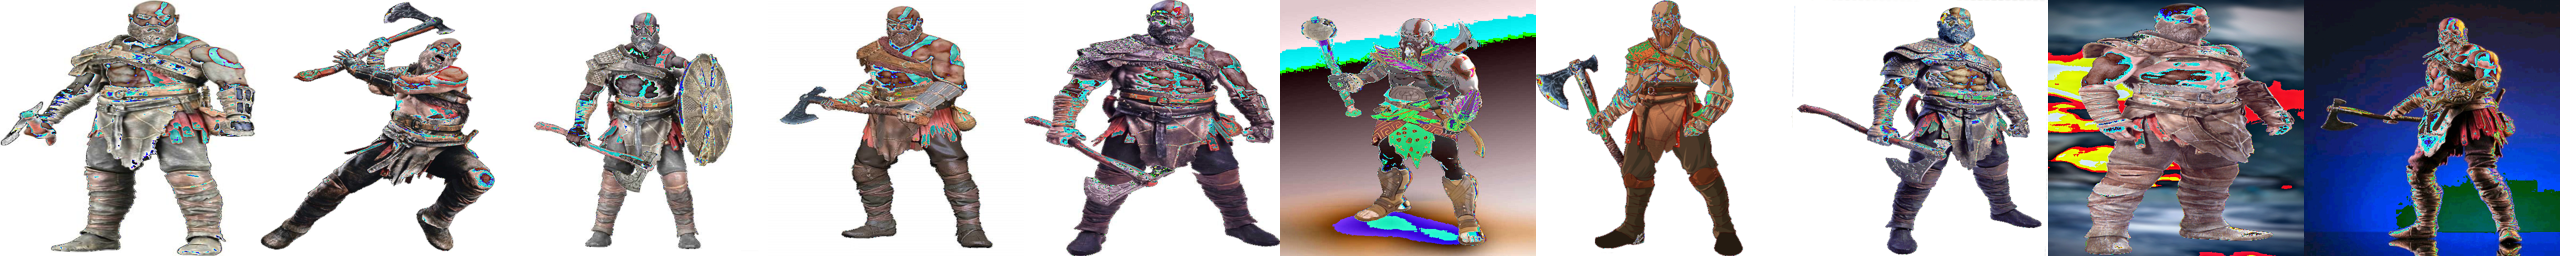

In [29]:
# visualize images after preprocessing

image_grid(
    [tensor2pil(image).resize((256, 256)) for image in batch['pixel_values']],
    rows=1,
    cols=len(batch['pixel_values'])
)

In [11]:
text_encoder = CLIPTextModel.from_pretrained(sd_ckpt, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(sd_ckpt, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(sd_ckpt, subfolder='unet')
feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')

In [12]:
batch_size = 1

train_dl = DataLoader(dataset=train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      collate_fn=collate_fn)

In [13]:
batch = next(iter(train_dl))
# batch

### Fine-tuning with Accelerate

In [14]:
# define sample prompts to visually assess the model during tranining
sample_prompts = [
    f'an illustration of {unique_token} {class_type} wearing a Santa hat in a snowy forest',
    f'a photograph of {unique_token} {class_type} reading a book on the beach',
    f'a sketch of {unique_token} {class_type} painting a mountain landscape',
    f'a drawing of {unique_token} {class_type} wearing a Spider-man costume in the style of Marvel comics'
]

# define training hyperparamters
args = Namespace(
    pretrained_model_name_or_path=sd_ckpt,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=2e-6,
    max_train_steps=880,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=2077,
    eval_batch_size=1,
    output_dir="my-dreambooth", # where to save the pipeline
    project_name='dreambooth-kratos',
    guidance_scale=7,
    train_text_encoder=True, # set to True to also fine-tune the text encoder
    eval_samples_every_epochs=5,
    sample_prompts=sample_prompts
)

In [15]:
# define training loop function

def train_fn(text_encoder, vae, unet):
    
    # init Accelerator
    accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps,
                              log_with="wandb",
                              logging_dir=os.path.join(args.output_dir, 'logs'))
    
    # set seed for reproducibility
    set_seed(args.seed)
    
    # disable text encoder fine-tuning
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)
    text_encoder.to(accelerator.device)
    
    vae.requires_grad_(False)
    vae.to(accelerator.device)
    
    feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')
    
    # enable gradient checkpointing
    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        
    # optimizer
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW
    
    # collate together models' parameters for optimization
    # ref. itertools.chain: https://discuss.pytorch.org/t/giving-multiple-parameters-in-optimizer/869/8?u=matteo_pilotto
    if args.train_text_encoder:
        params_to_optimize = itertools.chain(unet.parameters(), text_encoder.parameters())
    else:
        params_to_optimize = unet.parameters()
        
    optimizer = optimizer_class(params=params_to_optimize, lr=args.learning_rate)
    
    # init noise scheduler
    noise_scheduler = DDPMScheduler(
        beta_start=8.5e-4,
        beta_end=1.2e-2,
        beta_schedule='scaled_linear',
        num_train_timesteps=1000
    )
    
    # init inference scheduler
    inference_scheduler = PNDMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        skip_prk_steps=True,
        steps_offset=1,
    )
    
    # define train dataloader
    train_dl = DataLoader(dataset=args.train_dataset,
                          batch_size=args.train_batch_size,
                          collate_fn=collate_fn,
                          shuffle=True)
    
    # calculate the total number of epochs based on the number of training steps adjusted to grad. acc. steps
    train_steps_per_epoch = math.ceil(len(train_dl) / args.gradient_accumulation_steps)
    train_epochs = math.ceil(args.max_train_steps / train_steps_per_epoch)
    
    # total batch size
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
    
    # prepare unet, optimizer and train dataloader to work with Accelerate
    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dl = accelerator.prepare(unet, text_encoder, optimizer, train_dl)
    else:
        unet, optimizer, train_dl = accelerator.prepare(unet, optimizer, train_dl)
    
    # init tracker
    if accelerator.is_main_process:
        accelerator.init_trackers(project_name=args.project_name, config=args)
    
    # init WANDB table to collect and save sample outputs during training
    log_prompts = [prompt for prompt in args.sample_prompts for i in range(args.eval_batch_size)]
    log_table = wandb.Table(columns=['prompt'])
    for prompt in log_prompts:
        log_table.add_data(prompt)
    
    # init progress bar
    progress_bar = tqdm(range(args.max_train_steps), disable=(not accelerator.is_local_main_process))
    progress_bar.set_description('Steps')
    global_step = 0
    
    # training loop
    for epoch in range(train_epochs):
        unet.train()
        
        if args.train_text_encoder:
            text_encoder.train()
            
        for i, batch in enumerate(train_dl):
            with accelerator.accumulate(unet):
                
                # compute latents (i.e. image embeddings)
                with torch.inference_mode():
                    latents = vae.encode(batch['pixel_values']).latent_dist.sample()
                    latents *= 0.18215

                # init noise
                noise = torch.randn_like(latents).to(accelerator.device)

                # compute random timesteps
                batch_size = latents.shape[0]
                num_train_ts = noise_scheduler.num_train_timesteps
                timesteps = torch.tensor([random.randint(0, num_train_ts-1) for _ in range(batch_size)])
                timesteps = timesteps.to(accelerator.device)

                # add noise to latents
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # compute text embeddings
                # if text encoder fine-tuning is disable use inference mode
                if not args.train_text_encoder:
                    with torch.inference_mode():
                        text_embeds = text_encoder(batch['input_ids'])[0]
                    text_embeds = torch.clone(text_embeds)
                else:
                    text_embeds = text_encoder(batch['input_ids'])[0]
                

                # predict noise (forward pass)
                noise_pred = unet(noisy_latents, timesteps, text_embeds).sample

                # compute loss
                loss = F.mse_loss(noise_pred, noise, reduction='none').mean([1, 2, 3]).mean()

                # backward pass
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    if args.train_text_encoder:
                        params_to_clip = itertools.chain(unet.parameters(), text_encoder.parameters())
                    else:
                        params_to_clip = unet.parameters()
                
                # clip gradients
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)

                # optimizer step & zero grad
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
            
            # log values
            logs = {"loss": loss.detach().item(),
                    'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'step': global_step,
                    'epoch': epoch+1}
            
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break
                
        accelerator.wait_for_everyone()
        
        # Generate sample images for visual inspection
        if accelerator.is_main_process:
            if (epoch+1) % args.eval_samples_every_epochs == 0:
                print(f'[INFO] Generating samples for Epoch {epoch+1}...')
                
                # init pipeline with latest parameters
                pipeline = StableDiffusionPipeline(
                    text_encoder=accelerator.unwrap_model(text_encoder),
                    vae=vae,
                    unet=accelerator.unwrap_model(unet),
                    tokenizer=tokenizer,
                    scheduler=inference_scheduler,
                    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
                    feature_extractor=feature_extractor,
                ).to(accelerator.device)
                
                sample_images = []
                
                # loop over sample prompts
                for sample_prompt in sample_prompts:
                    
                    # set generator for reproducibility
                    generator = torch.Generator(device=pipeline.device).manual_seed(args.seed)
                
                    # run generative pipeline in inference mode (sample random noise and denoise)
                    for _ in range(args.eval_batch_size):
                        print(f'[INFO] generating image for "{sample_prompt}" prompt...')
                        images = pipeline(
                            prompt=sample_prompt,
                            guidance_scale=args.guidance_scale,
                            generator=generator).images
                        
                        sample_images.extend(images)
                        
                # log images to visually them during training
                log_images = [wandb.Image(image) for image in sample_images]
                accelerator.trackers[0].log({"sample images": log_images})
                
                # add images to WANDB table
                log_table.add_column(name=f'epoch_{epoch+1}', data=log_images)
    
    
    if accelerator.is_main_process:
        # log WANDB table at the of training
        accelerator.trackers[0].log({'table': log_table})
    
    if accelerator.is_main_process:
        # load and save final models
        print(f'[INFO] Loading pipeline and saving it to {args.output_dir}')
        
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=inference_scheduler,
            feature_extractor=feature_extractor,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained('CompVis/stable-diffusion-safety-checker')
        )
        
        pipeline.save_pretrained(args.output_dir)

    accelerator.end_training()

In [ ]:
from accelerate import notebook_launcher

# init stable diffusion components
text_encoder = CLIPTextModel.from_pretrained(sd_ckpt, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(sd_ckpt, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(sd_ckpt, subfolder='unet')
feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')

num_of_gpus = 1
notebook_launcher(train_fn, args=(text_encoder, vae, unet), num_processes=num_of_gpus)

### Save model to WANDB

In [ ]:
# SAVE MODEL'S CHECKPOINT ON WANDB 
# ref: https://docs.wandb.ai/guides/track/advanced/resuming
# ref: https://docs.wandb.ai/ref/python/artifact

PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
MODEL_PATH = './my-dreambooth'

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    artifact = wandb.Artifact(RUN_ID, type='model')
    artifact.add_dir(MODEL_PATH)
    run.log_artifact(artifact)

### Download model from WANDB

In [17]:
# DOWNLOAD MODEL'S CHECKPOINT FROM WANDB

PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    artifact = wandb.use_artifact(f'matt24/{PROJECT_NAME}/{RUN_ID}:v0', type='model')
    artifact_dir = artifact.download()

print(f'[INFO] Artifact directory: {artifact_dir}')

wandb: Downloading large artifact ay51iqly:v0, 5229.05MB. 15 files... 
wandb:   15 of 15 files downloaded.  
Done. 0:0:1.1


[INFO] Artifact directory: ./artifacts/ay51iqly:v0


### Inference

In [18]:
load_from_wandb = True

if load_from_wandb:
    print('[INFO] Loading fine-tuned model from WANDB...')
    pipeline = StableDiffusionPipeline.from_pretrained(artifact_dir, torch_dtype=torch.float16).to(device)
else:
    print('[INFO] Load fine-tuned model from local directory...')
    pipeline = StableDiffusionPipeline.from_pretrained(args.output_dir, torch_dtype=torch.float16).to(device)

[INFO] Loading fine-tuned model from WANDB...


In [ ]:
# number of images to generate
num_samples = 16

prompt = f"An illustration of {unique_token} {class_type} num_samples punk playing electric guitar, tristan eaton, victo ngai, artgerm, rhads, ross draws, 4k"
negative_prompt = 'low contrast, blurry, low resolution, warped'
use_negative_prompt = True
guidance_scale = 7
h = 512
w = 512
num_inference_steps = 50


# wdefine variables to log samples outputs to WANDB
PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
inference_table_name = 'inference_table'
log_table_cols = [
    'image',
    'prompt',
    'negative prompt',
    'resolution',
    'guidance scale',
    'inference steps',
    'seed'
]

# keep track of time (set time zone based on your location)
current_time = datetime.datetime.now(pytz.timezone('Europe/Amsterdam')).strftime("%Y-%m-%d_%H-%M-%S")

# initialize WANDB artficat and table
inference_artifact = wandb.Artifact(f'inference_artifact_{current_time}', type='inference') 
inference_log_table = wandb.Table(columns=log_table_cols)

# collect outputs
all_images = []
all_seeds = []



# generate images
for _ in tqdm(range(num_samples)):
    seed = random.randint(1, 1000000)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt,
                      negative_prompt=negative_prompt if use_negative_prompt else None,
                      guidance_scale=guidance_scale,
                      height=h,
                      width=w,
                      num_inference_steps=num_inference_steps,
                      generator=generator
                     ).images[0]
    
    inference_log_table.add_data(
        wandb.Image(image),
        prompt,
        negative_prompt if use_negative_prompt else None,
        f'{w} x {h}',
        guidance_scale,
        num_inference_steps,
        seed
    )
    
    all_images.append(image)
    all_seeds.append(seed)

inference_artifact.add(inference_log_table, 'inference_table')


with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    print(f'[💡INFO] Saving dato to {inference_table_name}_{current_time}...')
    run.log_artifact(inference_artifact)
    
    
image_grid([image.resize((256, 256)) for image in all_images], 1, num_samples)

### Push on the Hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
# Create a name for your model on the Hub. No spaces allowed.
model_name = f'{unique_token}_{class_type}'
print(model_name)


theme = 'wildcard'

# Describe the theme and model you've trained
description = f"""
This is a Stable Diffusion model fine-tuned on imagaes of Kratos from God of War for the {theme} theme using `CompVis/stable-diffusion-v1-4` pre-trained model.
"""

print(description)

In [ ]:
!cp -r ./artifacts/ay51iqly:v0 ./my-dreambooth

In [ ]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- {theme}
---

# DreamBooth model for the {name_of_your_concept} concept trained by {api.whoami()["name"]} on the {dataset_id} dataset.

This is a Stable Diffusion model fine-tuned on the {name_of_your_concept} concept with DreamBooth. It can be used by modifying the `instance_prompt`: **{instance_prompt}**

This model was created as part of the DreamBooth Hackathon 🔥. Visit the [organisation page](https://huggingface.co/dreambooth-hackathon) for instructions on how to take part!

## Description

{description}



## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(
    f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard"
)